# Ingeniería de features a partir de detecciones

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

In [2]:
def load_detections_csv(filename):
    det_columns = ["frame_num","class_idx", "x","y","w","h","score"]
    df = pd.read_csv(filename,names=det_columns)
    return df
df_det = load_detections_csv("detections.csv")
df_det.head()

,frame_num,class_idx,x,y,w,h,score
0,0,0,860.0,361.0,140.0,137.0,0.742915
1,0,0,696.0,387.0,111.0,104.0,0.620522
2,1,0,860.0,361.0,140.0,137.0,0.742915
3,1,0,696.0,387.0,111.0,104.0,0.620522
4,2,0,862.0,361.0,137.0,137.0,0.657860


Ingeniería de features básica.

In [102]:
total_frames = df_det.frame_num.max()-df_det.frame_num.min()

# Tiempo relativo
fps = 29.0
df_det['ts'] = df_det['frame_num']/fps
df_det['ts'] = pd.to_timedelta(df_det['ts'], unit='s')

# Centrado de coordenadas de BBs
df_det['xc'] = df_det['x']+df_det['w']/2
df_det['yc'] = df_det['y']+df_det['h']/2

# Área de los BBs
df_det['area'] = df_det['w']*df_det['h']

df_det.head()

,frame_num,class_idx,x,y,w,h,score,ts,area,xc,yc
0,0,0,860.0,361.0,140.0,137.0,0.742915,0 days 00:00:00,19180.0,930.0,429.5
1,0,0,696.0,387.0,111.0,104.0,0.620522,0 days 00:00:00,11544.0,751.5,439.0
2,1,0,860.0,361.0,140.0,137.0,0.742915,0 days 00:00:00.034482759,19180.0,930.0,429.5
3,1,0,696.0,387.0,111.0,104.0,0.620522,0 days 00:00:00.034482759,11544.0,751.5,439.0
4,2,0,862.0,361.0,137.0,137.0,0.657860,0 days 00:00:00.068965517,18769.0,930.5,429.5


In [66]:
df_det.ts.max()

Timedelta('0 days 00:10:27.724137931')

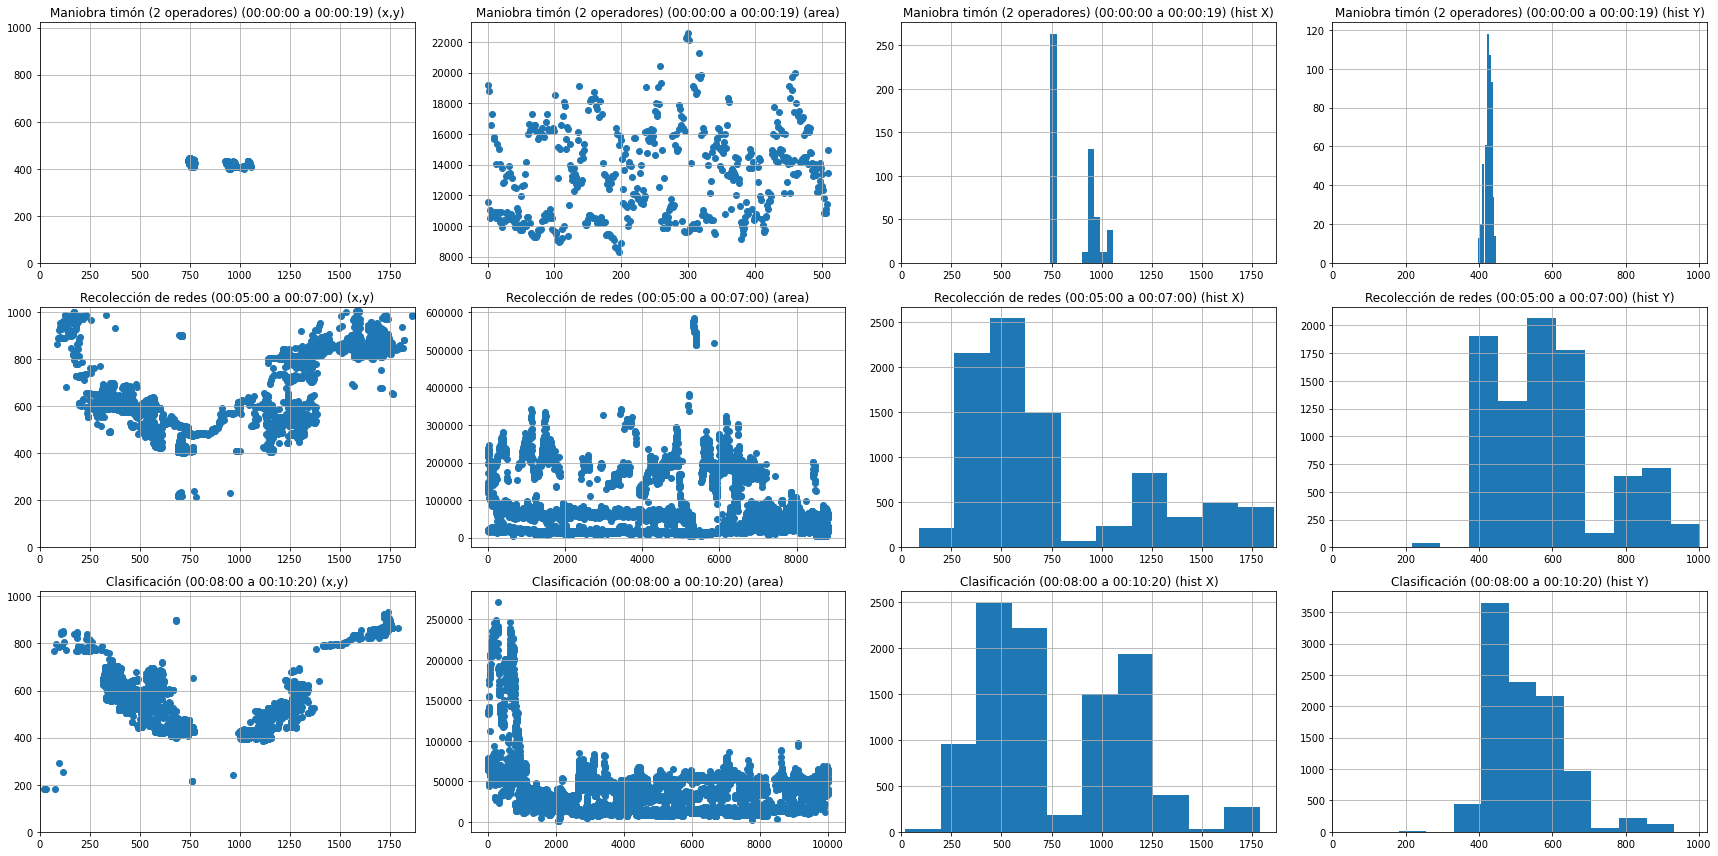

In [107]:
interesting_intervals = [    
    ("Maniobra timón (2 operadores)", '00:00:00', '00:00:19' ),
    ("Recolección de redes", '00:05:00', '00:07:00' ),
    ("Clasificación", '00:08:00', '00:10:20' )
]

n = len(interesting_intervals)
fig,axes = plt.subplots(n,4,figsize=(24,4*n),squeeze=False)
for i,r in enumerate(interesting_intervals):    
    frame_range_filter = (df_det.ts>r[1]) & (df_det.ts<r[2])
    axes[i][0].scatter(df_det[frame_range_filter].xc, df_det[frame_range_filter].yc)
    axes[i][0].set_title("%s (%s a %s) (x,y)" % (r[0],r[1],r[2]) )
    axes[i][0].set_xlim(0,df_det.x.max())
    axes[i][0].set_ylim(0,df_det.y.max())
    axes[i][0].grid(which='Both')
    
    axes[i][1].scatter(np.arange(len(df_det[frame_range_filter].area)),df_det[frame_range_filter].area)
    axes[i][1].set_title("%s (%s a %s) (area)" % (r[0],r[1],r[2]) )    
    axes[i][1].grid(which='Both')
    
    axes[i][2].hist(df_det[frame_range_filter].xc)
    axes[i][2].set_title("%s (%s a %s) (hist X)" % (r[0],r[1],r[2]) )
    axes[i][2].set_xlim(0,df_det.x.max())
    axes[i][2].grid(which='Both')
    
    axes[i][3].hist(df_det[frame_range_filter].yc)
    axes[i][3].set_title("%s (%s a %s) (hist Y)" % (r[0],r[1],r[2]) )
    axes[i][3].set_xlim(0,df_det.y.max())
    axes[i][3].grid(which='Both')
plt.tight_layout()
